#### Necessary libraries and functions

In [184]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression


def evaluate_model(model_name, model, X, y):
    
    predictions_probas = model.predict_proba(X)[:,1]
    predictions = model.predict(X)

    Accuracy = accuracy_score(y, predictions)
    AUC = roc_auc_score(y, predictions_probas)
    LogLoss = log_loss(y, predictions_probas)

    print('Accuracy for', model_name, ': %1.3f' % Accuracy)
    print('AUC for', model_name, ': %1.4f' % AUC)
    print('LogLoss for', model_name, ': %1.3f' % LogLoss)
    
    
def plot_fpr_fnr(model, model_name, x, y):
    
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(x)[:,1])
    fnr = 1 - tpr

    plt.figure(figsize = (9, 4))
    sns.lineplot(thresholds, fpr, label = 'FPR')
    sns.lineplot(thresholds, fnr, label = 'FNR')
    plt.xlim(0, 1)
    plt.xticks(np.arange(0, 1.01, 0.05), fontsize = 8)
    plt.yticks(np.arange(0, 1.01, 0.1), fontsize = 8)
    plt.title('FPR and FNR plots for ' + model_name + '\n')
    plt.xlabel('Thresholds')
    plt.ylabel('Rates')
    plt.grid(linestyle = "--", color = 'black', alpha = 1/3, linewidth = 1/2)
    plt.show()
    
    
def plot_roc_auc(model, model_name, x, y):
    
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(x)[:,1])
    
    plt.figure(figsize = (9, 4))
    sns.lineplot(fpr, tpr, color = 'red', label = 'ROC curve (area = %0.2f)' % auc(fpr, tpr))
    sns.lineplot([0, 1], [0, 1], color = 'black')
    plt.xlim(0, 1)
    plt.xticks(np.arange(0, 1.01, 0.05), fontsize = 8)
    plt.yticks(np.arange(0, 1.01, 0.1), fontsize = 8)
    plt.title('ROC curve and AUC for ' + model_name + '\n')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid(linestyle = "--", color = 'black', alpha = 1/3, linewidth = 1/2)
    plt.show()
    
    
def print_confusion_matrix(model, model_name, threshold, x, y):
    
    predictions = (model.predict_proba(x)[:,1] > threshold).astype(int)

    unnormalized_confusion_matrix = pd.DataFrame(confusion_matrix(y, predictions, normalize = None), 
                 columns = pd.MultiIndex.from_tuples([('PREDICTED', 'not_satisfied'), ('PREDICTED', 'satisfied')]),
                 index = pd.MultiIndex.from_tuples([('TRUE', 'not_satisfied'), ('TRUE', 'satisfied')]))

    normalized_confusion_matrix = pd.DataFrame(confusion_matrix(y, predictions, normalize = 'true'), 
                 columns = pd.MultiIndex.from_tuples([('PREDICTED', 'not_satisfied'), ('PREDICTED', 'satisfied')]),
                 index = pd.MultiIndex.from_tuples([('TRUE', 'not_satisfied'), ('TRUE', 'satisfied')]))
    
    print('Confusion matrices for', model_name, 'at threshold', threshold, '\n')

    print(unnormalized_confusion_matrix)
    print('\n')
    print(normalized_confusion_matrix)
    
    
import warnings 
warnings.filterwarnings('ignore')

#### Data we'll be working with

In [5]:
data = pd.read_csv('../data/airlines_cleaned.csv')
data = data.sample(10000, random_state = 20202020)
data.head()

is_male  is_loyal_customer  age  is_business_travel     class  \
90130        0                  1   31                   1  Business   
92           1                  1   30                   1  Business   
94807        1                  1   34                   1       Eco   
88000        0                  1   36                   1  Business   
36164        1                  1   66                   1  Business   

       flight distance  inflight wifi service  \
90130             3113                      3   
92                1896                      4   
94807              201                      3   
88000             2920                      1   
36164              190                      0   

       departure/arrival time convenient  ease of online booking  \
90130                                  1                       1   
92                                     1                       1   
94807                                  4                       4   
88000                                  1                       1   
36164                                  4                       0   

       gate location  ...  inflight entertainment  on-board service  \
90130              1  ...                       3                 1   
92                 1  ...                       4                 2   
94807              4  ...                       3                 2   
88000              1  ...                       5                 5   
36164              4  ...                       3                 3   

       leg room service  baggage handling  checkin service  inflight service  \
90130                 1                 4                4                 4   
92                    2                 3                4                 2   
94807                 2                 4                3                 4   
88000                 5                 5                3                 5   
36164                 3                 3                1                 3   

       cleanliness  departure delay in minutes  arrival delay in minutes  \
90130            3                           0                       1.0   
92               4                          81                      72.0   
94807            3                           3                       0.0   
88000            4                           0                      18.0   
36164            1                           0                       0.0   

       satisfied  
90130          0  
92             0  
94807          0  
88000          1  
36164          1  

[5 rows x 23 columns]

#### Usual train test split

In [6]:
X = data.drop('satisfied', 1).copy()
y = data['satisfied'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 20202020)

In [7]:
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

#### Applying a dummy classifier and a logistic regression to see how much a sophisticated ML algo can bring us closer to the truth

For non-CatBoost models we need to deal with categoricals. We can label or one-hot encode them, I'll use one-hot encoding

In [9]:
X_train_encoded = pd.get_dummies(X_train, columns = ['class'], prefix_sep = ' = ')
X_test_encoded = pd.get_dummies(X_test, columns = ['class'], prefix_sep = ' = ')

print('Original data has %g columns' % X_train.shape[1])
print('One hot encoded data has %g columns' % X_train_encoded.shape[1])

X_train_encoded.head()

Original data has 22 columns
One hot encoded data has 24 columns


is_male  is_loyal_customer  age  is_business_travel  flight distance  \
0        1                  1   36                   0              752   
1        0                  1   55                   0              409   
2        0                  1   55                   0              641   
3        0                  1   36                   0             1303   
4        1                  1   33                   1             1440   

   inflight wifi service  departure/arrival time convenient  \
0                      2                                  5   
1                      4                                  5   
2                      4                                  4   
3                      3                                  4   
4                      4                                  4   

   ease of online booking  gate location  food and drink  ...  \
0                       2              2               1  ...   
1                       4              1               2  ...   
2                       4              1               4  ...   
3                       3              5               4  ...   
4                       2              4               5  ...   

   leg room service  baggage handling  checkin service  inflight service  \
0                 5                 5                4                 4   
1                 4                 4                1                 4   
2                 4                 1                5                 1   
3                 3                 3                4                 4   
4                 4                 4                5                 4   

   cleanliness  departure delay in minutes  arrival delay in minutes  \
0            1                          84                      70.0   
1            4                          48                      45.0   
2            5                           0                       0.0   
3            4                           0                       0.0   
4            5                           0                       0.0   

   class = Business  class = Eco  class = Eco Plus  
0                 0            1                 0  
1                 0            1                 0  
2                 0            1                 0  
3                 0            1                 0  
4                 1            0                 0  

[5 rows x 24 columns]

Now applying the dummy

In [33]:
dummy = DummyClassifier(random_state = 20202020, strategy = 'most_frequent')
dummy.fit(X_train_encoded, y_train)

evaluate_model('Dummy classifier', dummy, X_test_encoded, y_test)

Accuracy for Dummy classifier : 0.583
AUC for Dummy classifier : 0.5000
LogLoss for Dummy classifier : 14.420


Now applying a simple linear regression

In [35]:
logreg = LogisticRegression(penalty = 'none', random_state = 20202020)
logreg.fit(X_train_encoded, y_train)

evaluate_model('Logistic regression', logreg, X_test_encoded, y_test)

Accuracy for Logistic regression : 0.792
AUC for Logistic regression : 0.8587
LogLoss for Logistic regression : 0.476


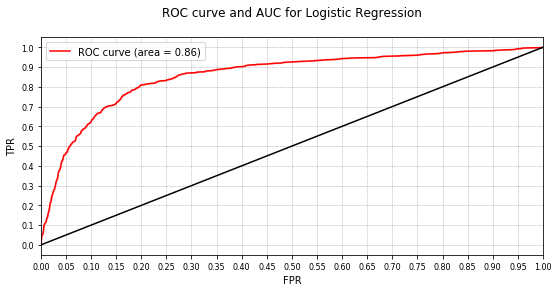

In [125]:
plot_roc_auc(logreg, 'Logistic Regression', X_test_encoded, y_test)

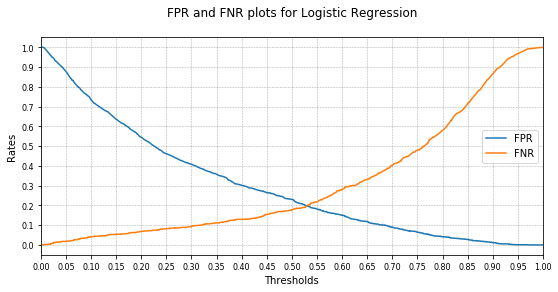

In [96]:
plot_fpr_fnr(logreg, 'Logistic Regression', X_test_encoded, y_test)

In [185]:
print_confusion_matrix(logreg, 'logistic regression', 0.7, X_test_encoded, y_test)

Confusion matrices for logistic regression at threshold 0.7 

                       PREDICTED          
                   not_satisfied satisfied
TRUE not_satisfied          1061       104
     satisfied               336       499


                       PREDICTED          
                   not_satisfied satisfied
TRUE not_satisfied      0.910730  0.089270
     satisfied          0.402395  0.597605


# Welcome to CatBoost

<img src="https://camo.githubusercontent.com/978ad57e1fba31f89403bdc139b9dbaffe70d32e88e31e4017897d902955dcad/687474703a2f2f73746f726167652e6d64732e79616e6465782e6e65742f6765742d646576746f6f6c732d6f70656e736f757263652f3235303835342f636174626f6f73742d6c6f676f2e706e67" style="width: 300px;"/>

- Open sourced by Yandex (Google of Russia)
- Product of 2017 (right away competitor of xgBoost and LightGBM)

Main advantages
1. Handling of categorical data without one-hot encoding
2. Great performance with default parameters
3. Model monitoring (live plots like in DL)
4. Overfit detection (~ early stop like in DL)
5. Snapshotting (in case of crashing no need to start from scratch)

Boosting-specific advantages
1. Multiple tree building methods (depthwise, leafwise, symmetric trees)
2. Eval metric vs custom metric vs loss function
3. Built in feature and object importances, feature interactions, feature analysis and SHAP values
4. Remaining time calculator
5. Evaluation timer (no need to calculate i.e. AUC after every round as it is expensive)

In [186]:
from catboost import CatBoostClassifier

In [187]:
X_train

is_male  is_loyal_customer  age  is_business_travel     class  \
0           1                  1   36                   0       Eco   
1           0                  1   55                   0       Eco   
2           0                  1   55                   0       Eco   
3           0                  1   36                   0       Eco   
4           1                  1   33                   1  Business   
...       ...                ...  ...                 ...       ...   
7995        0                  0   29                   1       Eco   
7996        1                  1   21                   1       Eco   
7997        0                  1   42                   1  Business   
7998        1                  0   48                   1       Eco   
7999        0                  1   30                   1  Business   

      flight distance  inflight wifi service  \
0                 752                      2   
1                 409                      4   
2                 641                      4   
3                1303                      3   
4                1440                      4   
...               ...                    ...   
7995             1195                      3   
7996              571                      1   
7997              283                      5   
7998              199                      3   
7999             3720                      2   

      departure/arrival time convenient  ease of online booking  \
0                                     5                       2   
1                                     5                       4   
2                                     4                       4   
3                                     4                       3   
4                                     4                       2   
...                                 ...                     ...   
7995                                  4                       4   
7996                                  5                       5   
7997                                  5                       5   
7998                                  3                       3   
7999                                  1                       1   

      gate location  ...  seat comfort  inflight entertainment  \
0                 2  ...             1                       1   
1                 1  ...             5                       4   
2                 1  ...             5                       1   
3                 5  ...             4                       4   
4                 4  ...             5                       5   
...             ...  ...           ...                     ...   
7995              1  ...             2                       2   
7996              5  ...             2                       1   
7997              5  ...             4                       4   
7998              1  ...             1                       1   
7999              1  ...             2                       2   

      on-board service  leg room service  baggage handling  checkin service  \
0                    3                 5                 5                4   
1                    4                 4                 4                1   
2                    1                 4                 1                5   
3                    4                 3                 3                4   
4                    4                 4                 4                5   
...                ...               ...               ...              ...   
7995                 5                 5                 3                4   
7996                 4                 4                 4                2   
7997                 4                 4                 4                4   
7998                 1                 3                 3                2   
7999                 2                 4                 3                3   

      inflight service  clean

## 1. Applying simple CatBoost (default, no tuning, no CV)

In [188]:
default_model = CatBoostClassifier(random_state = 20202020, 
                                   cat_features = ['class'],
                                   verbose = 100)
default_model.fit(X_train, y_train)

Learning rate set to 0.025035
0:	learn: 0.6613257	total: 204ms	remaining: 3m 24s
100:	learn: 0.1493226	total: 3.3s	remaining: 29.4s
200:	learn: 0.1192444	total: 6.48s	remaining: 25.8s
300:	learn: 0.1039515	total: 11.7s	remaining: 27.2s
400:	learn: 0.0934948	total: 16.5s	remaining: 24.7s
500:	learn: 0.0853796	total: 21.8s	remaining: 21.8s
600:	learn: 0.0792395	total: 27.4s	remaining: 18.2s
700:	learn: 0.0730000	total: 32.3s	remaining: 13.8s
800:	learn: 0.0665872	total: 36s	remaining: 8.95s
900:	learn: 0.0618335	total: 40.3s	remaining: 4.43s
999:	learn: 0.0575502	total: 44.2s	remaining: 0us


In [189]:
evaluate_model('CatBoost default', default_model, X_test, y_test)

Accuracy for CatBoost default : 0.956
AUC for CatBoost default : 0.9930
LogLoss for CatBoost default : 0.104


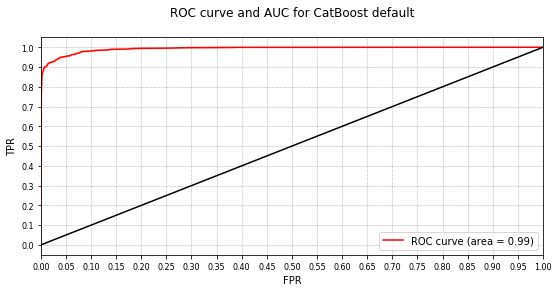

In [190]:
plot_roc_auc(default_model, 'CatBoost default', X_test, y_test)

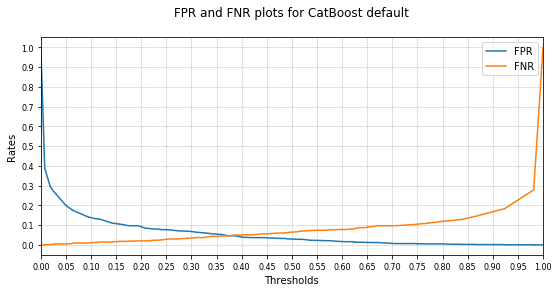

In [191]:
plot_fpr_fnr(default_model, 'CatBoost default', X_test, y_test)

In [193]:
print_confusion_matrix(default_model, 'CatBoost default', 0.375, X_test, y_test)

Confusion matrices for CatBoost default at threshold 0.375 

                       PREDICTED          
                   not_satisfied satisfied
TRUE not_satisfied          1111        54
     satisfied                40       795


                       PREDICTED          
                   not_satisfied satisfied
TRUE not_satisfied      0.953648  0.046352
     satisfied          0.047904  0.952096


### 1.1. What was the best score on the train set?

In [194]:
default_model.best_score_

{'learn': {'Logloss': 0.05755020440443223}}

CatBoost calculates LogLoss **by default for clasification**. For classification you can optimize for Logloss, CrossEntropy, MultiClass or MultiClassOneVsAll

- Supported metrics: https://catboost.ai/docs/references/custom-metric__supported-metrics.html
- Regression specific: https://catboost.ai/docs/concepts/loss-functions-regression.html
- Classification specific: https://catboost.ai/docs/concepts/loss-functions-classification.html


#### Let's monitor AUC and accuracy too

AUC is disabled by default for during-training monitoring, as its calculation is quite expensive on large scale. However you can do whatever you want, you just need to allow it with the *hints=skip_train~false* command

In [217]:
model = CatBoostClassifier(random_state = 20202020, 
                           cat_features = ['class'],
                           verbose = 100, 
                           custom_loss = ['AUC:hints=skip_train~false', 'Accuracy', 'Logloss'])
model.fit(X_train, y_train)

Learning rate set to 0.025035
0:	learn: 0.6613257	total: 31.3ms	remaining: 31.2s
100:	learn: 0.1493226	total: 3.15s	remaining: 28.1s
200:	learn: 0.1192444	total: 6.13s	remaining: 24.4s
300:	learn: 0.1039515	total: 9.21s	remaining: 21.4s
400:	learn: 0.0934948	total: 12.3s	remaining: 18.4s
500:	learn: 0.0853796	total: 15.5s	remaining: 15.5s
600:	learn: 0.0792395	total: 18.5s	remaining: 12.3s
700:	learn: 0.0730000	total: 21.5s	remaining: 9.18s
800:	learn: 0.0665872	total: 24.6s	remaining: 6.12s
900:	learn: 0.0618335	total: 27.7s	remaining: 3.04s
999:	learn: 0.0575502	total: 30.8s	remaining: 0us


In [218]:
model.best_score_

{'learn': {'Accuracy': 0.98575,
  'Logloss': 0.05755020440443223,
  'AUC': 0.9992947929448028}}

In [219]:
evaluate_model('CatBoost optimizing AUC', model, X_test, y_test)

Accuracy for CatBoost optimizing AUC : 0.956
AUC for CatBoost optimizing AUC : 0.9930
LogLoss for CatBoost optimizing AUC : 0.104


### 1.2. Reading the training history is great but let's *see* what's happening during training

In [222]:
model = CatBoostClassifier(num_trees = 500,
                           learning_rate = 0.05, 
                           random_state = 20202020, 
                           cat_features = ['class'],
                           custom_loss = ['AUC:hints=skip_train~false', 'Accuracy', 'Logloss'])

model.fit(X_train, y_train, eval_set = (X_test, y_test), plot = True, verbose = False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Okay, we're not overfitting, there's just less and less to learn

#### Let's overfit a little

In [223]:
model = CatBoostClassifier(num_trees = 500,
                           learning_rate = 0.5, 
                           random_state = 20202020, 
                           cat_features = ['class'],
                           custom_loss = ['AUC:hints=skip_train~false', 'Accuracy', 'Logloss'])

model.fit(X_train, y_train, eval_set = (X_test, y_test), plot = True, verbose = False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Setting the learning rate too high will  disallow the optimization function to get closer to the global minima. After the 83rd tree, out test error started increasing

In [224]:
print('Based on test error, you should only build %g trees' % (model.best_iteration_ + 1))

Based on test error, you should only build 83 trees


#### Bonus feature, plot two models on the same chart, compare their training history visually

In [225]:
from catboost import MetricVisualizer

In [228]:
large_lr = CatBoostClassifier(num_trees = 500,
                              learning_rate = 0.5, 
                              random_state = 20202020, 
                              cat_features = ['class'],
                              train_dir = 'lr=0.5',
                              custom_loss = ['AUC:hints=skip_train~false', 'Accuracy', 'Logloss'])

large_lr.fit(X_train, y_train, eval_set = (X_test, y_test), verbose = 100)

small_lr = CatBoostClassifier(num_trees = 500,
                              learning_rate = 0.05, 
                              random_state = 20202020, 
                              cat_features = ['class'],
                              train_dir = 'lr=0.05',
                              custom_loss = ['AUC:hints=skip_train~false', 'Accuracy', 'Logloss'])

small_lr.fit(X_train, y_train, eval_set = (X_test, y_test), verbose = 100)

0:	learn: 0.3287725	test: 0.3314837	best: 0.3314837 (0)	total: 35.4ms	remaining: 17.7s
100:	learn: 0.0261454	test: 0.1106227	best: 0.1086197 (82)	total: 3.3s	remaining: 13.1s
200:	learn: 0.0099241	test: 0.1169313	best: 0.1086197 (82)	total: 6.43s	remaining: 9.56s
300:	learn: 0.0068964	test: 0.1193604	best: 0.1086197 (82)	total: 9.48s	remaining: 6.26s
400:	learn: 0.0056938	test: 0.1237051	best: 0.1086197 (82)	total: 12.4s	remaining: 3.07s
499:	learn: 0.0049671	test: 0.1244409	best: 0.1086197 (82)	total: 15.2s	remaining: 0us

bestTest = 0.1086197298
bestIteration = 82

Shrink model to first 83 iterations.
0:	learn: 0.6312627	test: 0.6322870	best: 0.6322870 (0)	total: 27ms	remaining: 13.5s
100:	learn: 0.1186033	test: 0.1315546	best: 0.1315546 (100)	total: 2.98s	remaining: 11.8s
200:	learn: 0.0931533	test: 0.1165998	best: 0.1165969 (199)	total: 5.92s	remaining: 8.81s
300:	learn: 0.0790861	test: 0.1099860	best: 0.1099449 (299)	total: 8.83s	remaining: 5.84s
400:	learn: 0.0669185	test: 0.1063

In [229]:
MetricVisualizer(['lr=0.5', 'lr=0.05']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## 2. Will not tune, nor use CV - check CatBoostRegression notebook for that
I'll use the default CatBoostClassifier() and go into classification model evaluation, explanation

## 3. Model evaluation, explanation

CatBoost is a trees ensemble, therefore a blackbox model. We need to know why certain predictions happen, how the features impact the predictions. We can

1. Used built in roc_curve, FPR and FNR values calc - same as sklearn, so we have to do the plotting ourselves
2. Calculate feature importances when building trees and making splits
3. Calculate SHAP values to determine effect of features on given predictions
4. Find most important datapoints that drive decision making

<img src="https://miro.medium.com/max/875/1*2g4vm8lWZTLpEqbIFNQ4wg.png" style="width: 300px;"/>


### 3.1. FPR FNR plots

In [230]:
from catboost import Pool
from catboost.utils import get_confusion_matrix, get_fnr_curve, get_fpr_curve, get_roc_curve

Create a CatBoost Pool object. This is basically a dataset + metadata container. It keeps track of what is the X, what is the y, what are the categorical features and what are the names of all the features. It can be supplied to any CatBoost function, and then there's no need to separately mark X, y, etc...

In [231]:
train_pool = Pool(X_train, y_train, cat_features = ['class'])
test_pool = Pool(X_test, y_test, cat_features = ['class'])

#### Confusion matrices

In [232]:
get_confusion_matrix(model, test_pool)

array([[1123.,   42.],
       [  53.,  782.]])

Calcualted with 0.5 threshold - why isn't their a package that lets us set the threshold...? Anyways, we can always create one

In [239]:
print_confusion_matrix(model, 'CatBoost default', 0.5, X_test, y_test)

Confusion matrices for CatBoost default at threshold 0.5 

                       PREDICTED          
                   not_satisfied satisfied
TRUE not_satisfied          1123        42
     satisfied                53       782


                       PREDICTED          
                   not_satisfied satisfied
TRUE not_satisfied      0.963948  0.036052
     satisfied          0.063473  0.936527


#### ROC, FPR, FNR --> same as sklearn, so we have to build plotter functions ourselves

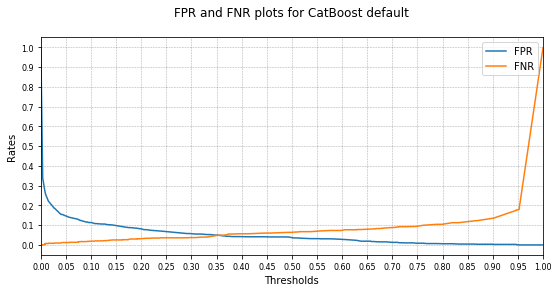

In [244]:
plot_fpr_fnr(model, 'CatBoost default', X_test, y_test)

Let's compare!

In [245]:
(thresholds, fpr) = get_fpr_curve(model, test_pool)
(thresholds, fnr) = get_fnr_curve(model, test_pool)

Text(0.5, 1.0, 'FPR-FNR curves from CatBoost library values')

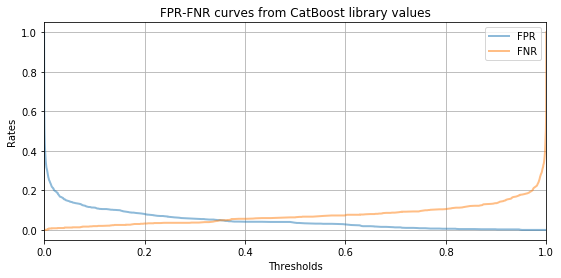

In [258]:
plt.figure(figsize=(9, 4))
style = {'alpha':0.5, 'lw':2}

sns.lineplot(thresholds, fpr, label = 'FPR', **style)
sns.lineplot(thresholds, fnr, label = 'FNR', **style)

plt.xlim([0.0, 1.0])
plt.grid(True)
plt.xlabel('Thresholds')
plt.ylabel('Rates')
plt.title('FPR-FNR curves from CatBoost library values')

#### Bonus feature - helps us decide on the threshold

In [254]:
from catboost.utils import select_threshold

In [288]:
print('I want to allow max 5% of FPR - I have to set the threshold to or above:', select_threshold(model, test_pool, FPR = 0.05))
print('Im OK allowing 10% of FNR - I have to set the threshold to or below:', select_threshold(model, test_pool, FNR = 0.1))

I want to allow max 5% of FPR - I have to set the threshold to or above: 0.3450545327561636
Im OK allowing 10% of FNR - I have to set the threshold to or below: 0.7629387611710632


In [295]:
print_confusion_matrix(model, 'CatBoost 5% FPR', 0.345, X_test, y_test)

Confusion matrices for CatBoost 5% FPR at threshold 0.345 

                       PREDICTED          
                   not_satisfied satisfied
TRUE not_satisfied          1107        58
     satisfied                38       797


                       PREDICTED          
                   not_satisfied satisfied
TRUE not_satisfied      0.950215  0.049785
     satisfied          0.045509  0.954491


In [293]:
print_confusion_matrix(model, 'CatBoost 10% FNR', 0.7629, X_test, y_test)

Confusion matrices for CatBoost 10% FNR at threshold 0.7629 

                       PREDICTED          
                   not_satisfied satisfied
TRUE not_satisfied          1156         9
     satisfied                83       752


                       PREDICTED          
                   not_satisfied satisfied
TRUE not_satisfied      0.992275  0.007725
     satisfied          0.099401  0.900599


### 3.2. Visualize metrics and feature statistics

#### 3.2.1. Eval metrics

In [296]:
model.eval_metrics(test_pool, ['AUC:hints=skip_train~false', 'Accuracy', 'Logloss'], plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'AUC': [0.9471208655650073,
  0.9717432088612474,
  0.9792110200200458,
  0.9843118912389812,
  0.9855943049523271,
  0.9858656935056925,
  0.9866968209503739,
  0.9865899103081391,
  0.9872581018221068,
  0.9879401711598262,
  0.9881570764051296,
  0.9884680424558608,
  0.9886222404975457,
  0.9887425149700598,
  0.9891064223484362,
  0.9892462285728971,
  0.9894261262881962,
  0.9895823803037701,
  0.9896563953637789,
  0.9896265837423864,
  0.9896306956901647,
  0.9896265837423864,
  0.9895207010870962,
  0.9895957441340495,
  0.9900922618282748,
  0.9900675901416052,
  0.9900819819588291,
  0.9904880368019326,
  0.9903317827863586,
  0.9903132790213565,
  0.9901488011102259,
  0.9902043124052324,
  0.99012721338439,
  0.9900233867029888,
  0.9901405772146694,
  0.9901847806532857,
  0.9901950605227313,
  0.9905312122536044,
  0.9905229883580479,
  0.9904325255069261,
  0.9906124232222251,
  0.9906463467913957,
  0.9904993446583228,
  0.9904664490760967,
  0.9905209323841587,
  0.9

#### 3.2.2. Feature statistics

Don't forget, this is a classification problem! The loss function was logloss, the predictions are actually log odds! We can of course predict probabilities, which is just the exp of the log odds. I'll demonstrate

In [374]:
print('Log odds prediction:\t\t\t', model.predict_log_proba(X_train)[1])
print('Log odds for being positive (=1):\t', model.predict_log_proba(X_train)[1][1])

print('Log odds --> probability manually:\t', np.exp(model.predict_log_proba(X_train)[1][1]))
print('Probability predicted by model:\t\t', model.predict_proba(X_train)[1][1])

Log odds prediction:			 [-0.02154522 -3.84835436]
Log odds for being positive (=1):	 -3.848354363860523
Log odds --> probability manually:	 0.021314783971532882
Probability predicted by model:		 0.021314783971532886


In [304]:
model.calc_feature_statistics(X_train, y_train, 'departure delay in minutes', prediction_type = 'Probability')

{'borders': array([  0.5,   1.5,   3.5,   4.5,   7.5,  15.5,  35.5,  50.5,  62.5,
        105.5, 111.5, 130.5, 151.5, 178.5, 184.5, 185.5, 192. ],
       dtype=float32),
 'binarized_feature': array([9, 7, 0, ..., 6, 4, 6]),
 'mean_target': array([0.45205778, 0.42629483, 0.4680851 , 0.42519686, 0.47567567,
        0.43731344, 0.37823835, 0.36842105, 0.40689656, 0.354717  ,
        0.44444445, 0.43103448, 0.4       , 0.25531915, 0.5       ,
        1.        , 0.5714286 , 0.625     ], dtype=float32),
 'mean_weighted_target': array([], dtype=float32),
 'mean_prediction': array([0.4519119 , 0.43198526, 0.463204  , 0.42761365, 0.47554287,
        0.4361432 , 0.37986585, 0.36940232, 0.3972835 , 0.36101598,
        0.43628314, 0.42769775, 0.38560185, 0.26963758, 0.49341133,
        0.87384665, 0.5763276 , 0.6004029 ], dtype=float32),
 'objects_per_bin': array([4568,  251,  329,  127,  370,  670,  772,  304,  145,  265,   27,
          58,   45,   47,    6,    1,    7,    8], dtype=uint32),
 '

In [305]:
model.calc_feature_statistics(X_train, y_train, 'age', prediction_type = 'Probability')

{'borders': array([ 8.5,  9.5, 14.5, 19.5, 21.5, 24.5, 25.5, 29.5, 31.5, 32.5, 33.5,
        34.5, 35.5, 36.5, 37.5, 40.5, 41.5, 42.5, 43.5, 44.5, 45.5, 50.5,
        55.5, 57.5, 58.5, 60.5, 61.5, 63.5, 64.5, 66.5, 69.5, 77.5],
       dtype=float32),
 'binarized_feature': array([13, 22, 22, ..., 17, 21,  8]),
 'mean_target': array([0.13265306, 0.10869565, 0.14624506, 0.25141242, 0.32882884,
        0.4082397 , 0.35858586, 0.32178217, 0.3878327 , 0.46341464,
        0.38857144, 0.3853211 , 0.3986014 , 0.3292683 , 0.33678755,
        0.4976744 , 0.61494255, 0.5846154 , 0.58247423, 0.6178344 ,
        0.6       , 0.5682614 , 0.58793324, 0.59539473, 0.5714286 ,
        0.5542636 , 0.34848484, 0.2       , 0.24615385, 0.275     ,
        0.15060242, 0.13580246, 0.33333334], dtype=float32),
 'mean_weighted_target': array([], dtype=float32),
 'mean_prediction': array([0.13485214, 0.12309494, 0.14099689, 0.2536806 , 0.3267309 ,
        0.40816563, 0.3591919 , 0.322423  , 0.39026344, 0.46361294,

### 3.3. Feature importances

#### 3.3.1. Simple feature importances

1. PredictionValuesChange - how much on average the prediction changes if the feature value changes
2. LossFunctionChange - difference between the loss function obtained using the model in normal scenario (when we include the feature) and model without this feature (model is built approximately using the original model with this feature removed from all the trees in the ensemble). Higher the difference, the more important the feature is

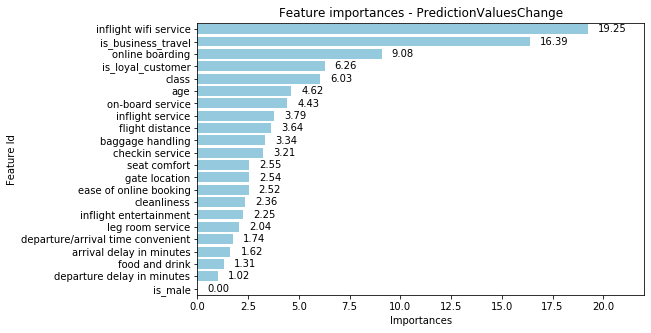

In [344]:
PredictionValuesChange = model.get_feature_importance(train_pool, type = 'PredictionValuesChange', prettified = True)

fig, ax = plt.subplots(figsize = (8, 5))
sns.barplot(x = 'Importances', y = 'Feature Id', data = PredictionValuesChange, color = 'skyblue', ax = ax)
for p in ax.patches:
    width = p.get_width()    
    ax.text(width + 0.5, p.get_y() + p.get_height() / 2, 
            '{:1.2f}'.format(width), ha = 'left', va = 'center', size = 10) 
plt.xlim(0, 22)
plt.title('Feature importances - PredictionValuesChange')
plt.show()

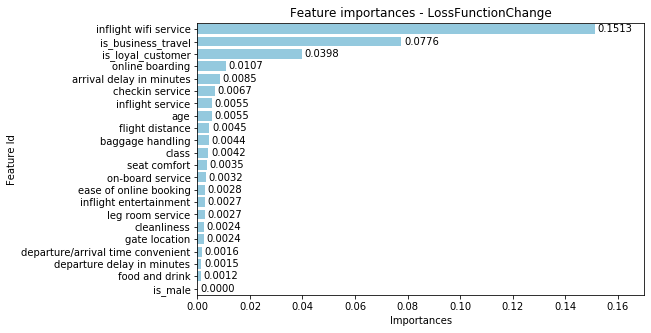

In [345]:
LossFunctionChange = model.get_feature_importance(train_pool, type = 'LossFunctionChange', prettified = True)

fig, ax = plt.subplots(figsize = (8, 5))
sns.barplot(x = 'Importances', y = 'Feature Id', data = LossFunctionChange, color = 'skyblue', ax = ax)
for p in ax.patches:
    width = p.get_width()    
    ax.text(width + 0.001, p.get_y() + p.get_height() / 2, 
            '{:1.4f}'.format(width), ha = 'left', va = 'center', size = 10) 
plt.xlim(0, 0.17)
plt.title('Feature importances - LossFunctionChange')
plt.show()

#### 3.3.2. SHAP values

In [346]:
import shap
shap.initjs()

Again, by default we'd be predicting log odds and explaining log odds. We want probabilities

<img src="https://www.rips-irsp.com/article/10.5334/irsp.90/irsp-30-90-g2.png" style="width: 700px;"/>


In [386]:
shap_values = model.get_feature_importance(train_pool, type = 'ShapValues')

In [387]:
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

In [388]:
print(shap_values.shape)
print(X_train.shape)

(8000, 22)
(8000, 22)


Plot a couple of predictions

In [389]:
print('Predicted value:', model.predict_proba(X_train)[2][1])
print('Actual value:', y_train.iloc[2])

Predicted value: 0.8780735512325913
Actual value: 1


In [390]:
shap.force_plot(expected_value, shap_values[2,:], X_train.iloc[2,:], link = 'logit')

#### CatBoost's internal SHAP explainer does not yet support probability explainer waterfalls (force plots do tho), so below we can keep track of how the log odds were changing

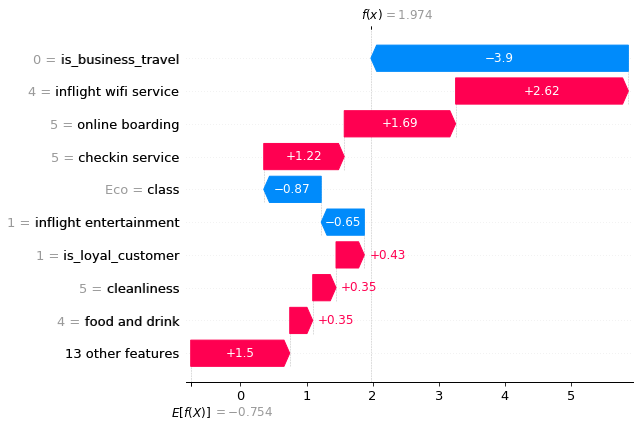

In [393]:
shap.plots._waterfall.waterfall_legacy(expected_value, shap_values[2, :], 
                                       features = X_train.iloc[2,:], )

Plot a summary plot

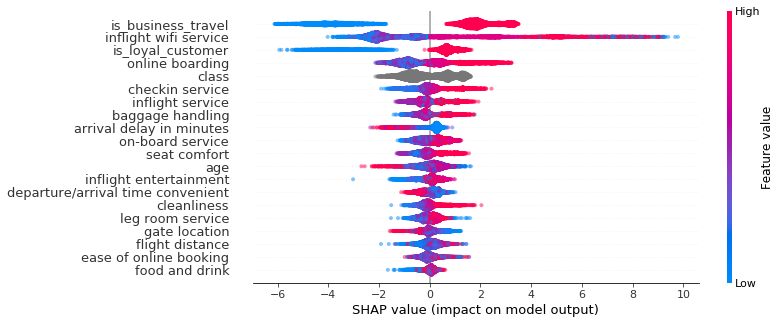

In [391]:
shap.summary_plot(shap_values, X_train, plot_type = 'dot', plot_size = (10, 5), alpha = 1/2)

Plot dependency plots

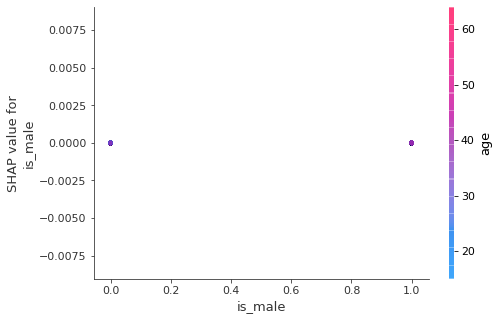

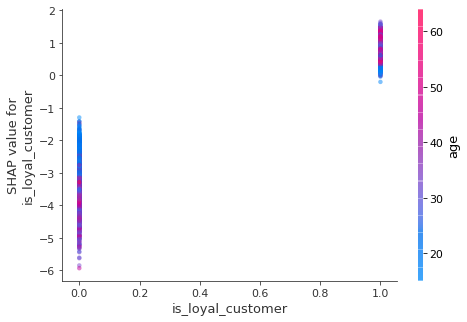

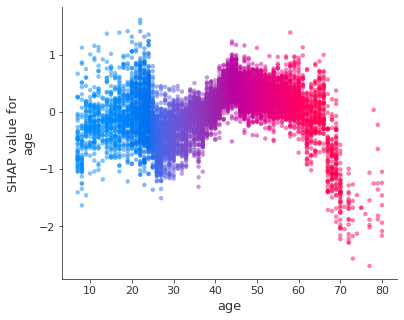

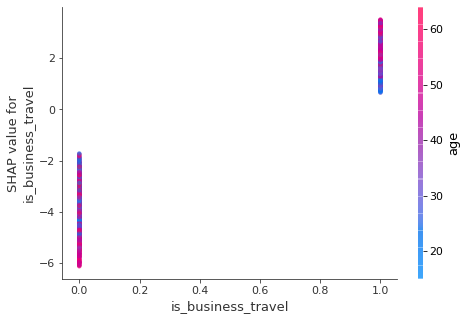

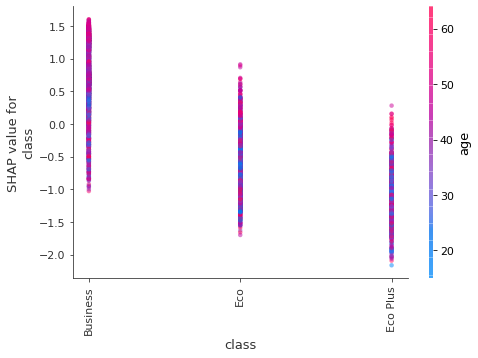

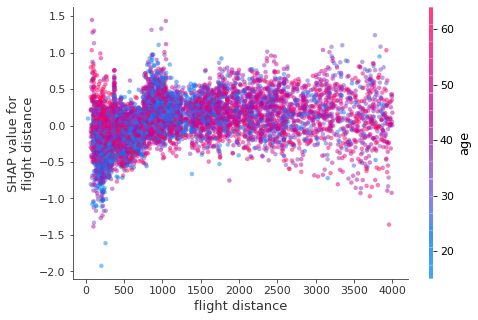

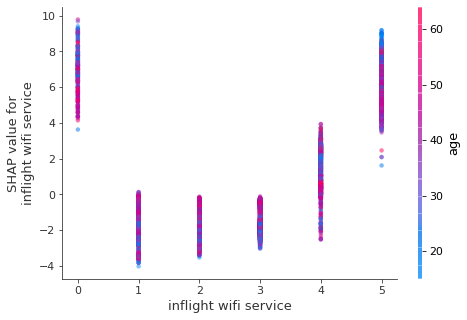

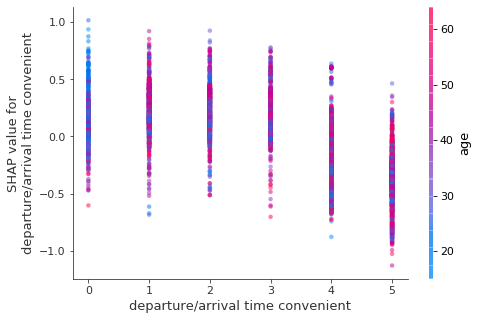

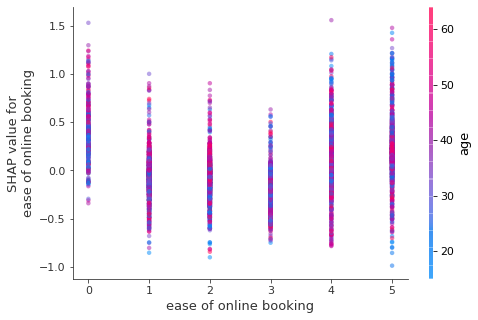

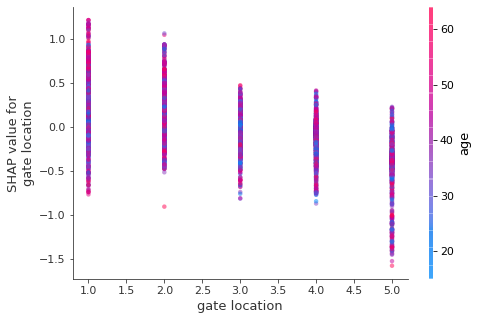

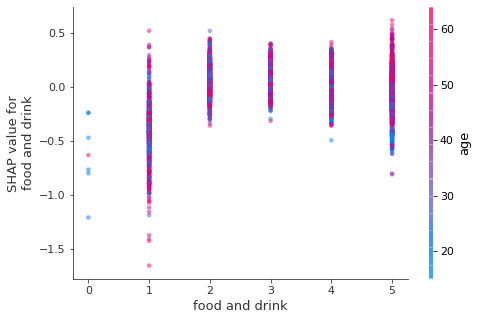

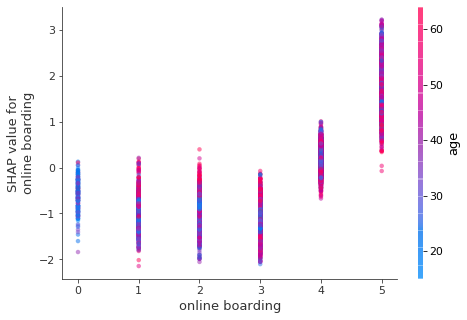

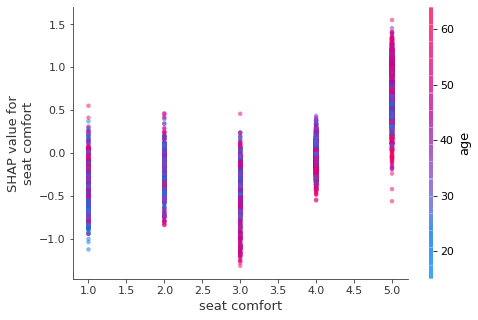

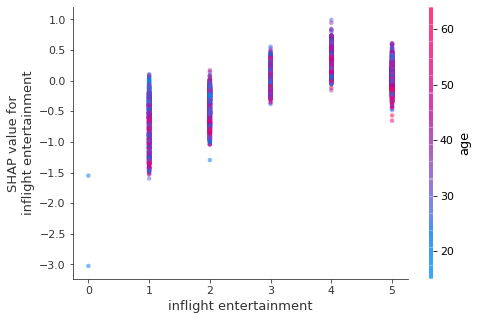

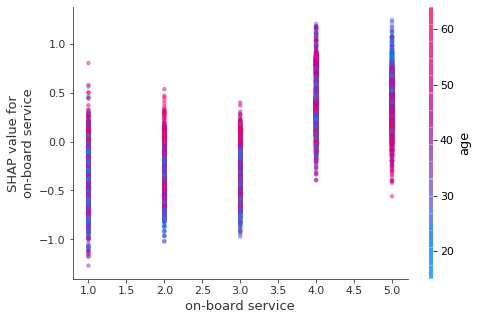

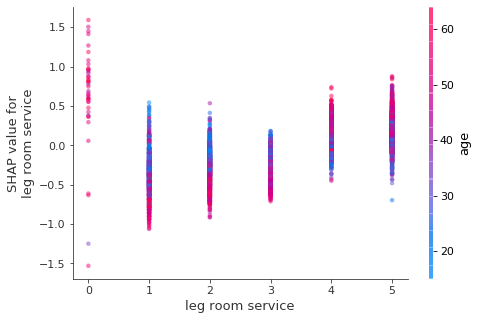

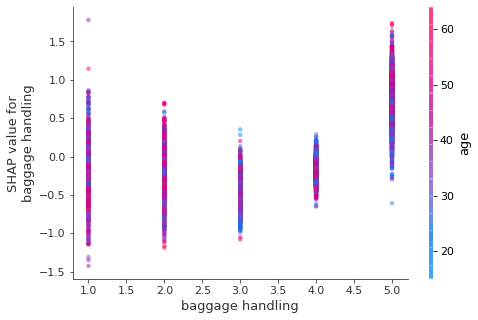

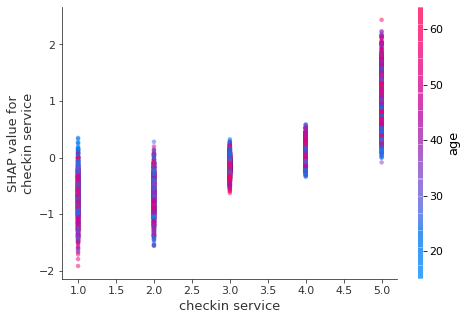

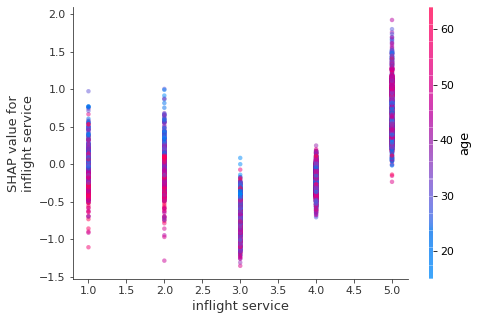

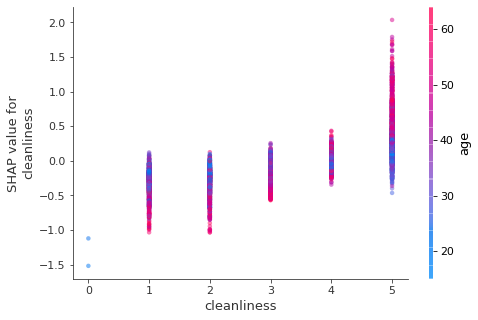

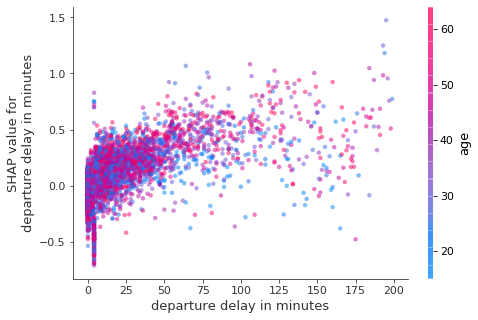

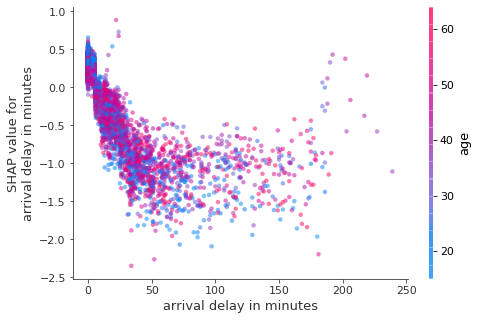

In [392]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train, dot_size = 20, alpha = 1/2, interaction_index = 'age')

#### 3.3.3. Feature interactions

In [396]:
interactions = model.get_feature_importance(train_pool, type = 'Interaction', prettified = True)
mapper = dict(zip(np.linspace(0, len(X_train.columns) - 1, len(X_train.columns)).astype('int').tolist(), X_train.columns.tolist()))
interactions.replace({'First Feature Index' : mapper, 'Second Feature Index' : mapper}, inplace = True)

interactions

First Feature Index      Second Feature Index  Interaction
0                inflight wifi service           online boarding     2.539876
1                                  age     inflight wifi service     2.539764
2                   is_business_travel     inflight wifi service     2.012415
3                    is_loyal_customer                       age     1.865544
4                      flight distance     inflight wifi service     1.854645
..                                 ...                       ...          ...
197                   inflight service  arrival delay in minutes     0.008040
198  departure/arrival time convenient             gate location     0.005881
199                 is_business_travel             gate location     0.005762
200                       seat comfort          inflight service     0.004588
201                              class            food and drink     0.003451

[202 rows x 3 columns]

In [397]:
interactions_ = interactions.copy()
interactions_['First Feature Index'] = interactions['Second Feature Index']
interactions_['Second Feature Index'] = interactions['First Feature Index']

interactions_complete = pd.concat([interactions, interactions_])

In [398]:
interactions_complete = interactions_complete.pivot_table(index = 'First Feature Index', 
                                                          columns = 'Second Feature Index', 
                                                          values = 'Interaction', 
                                                          aggfunc = 'mean', fill_value = 0)

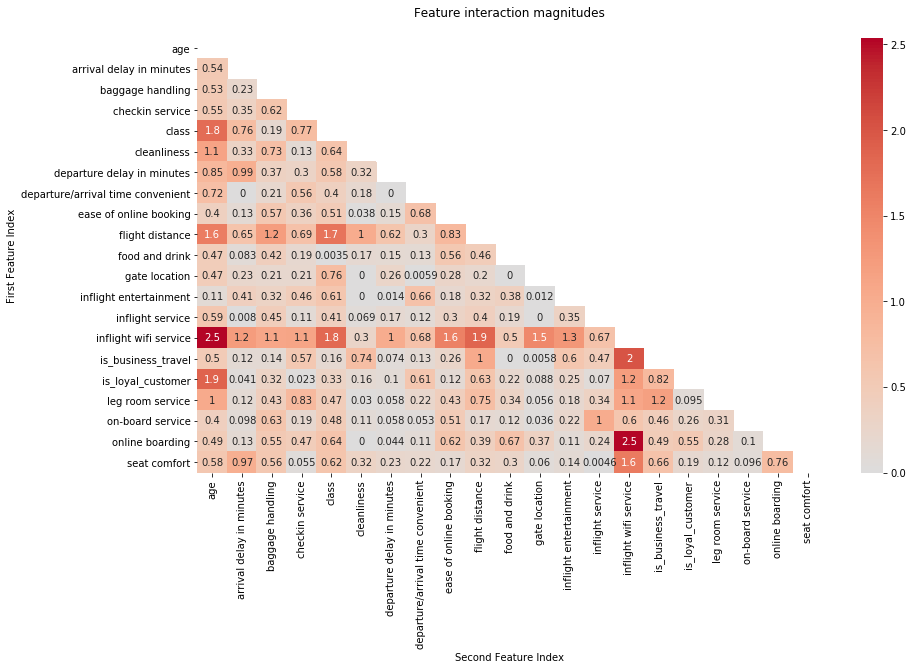

In [400]:
mask = np.triu(np.ones_like(interactions_complete, dtype = bool))

plt.figure(figsize = (14, 8))
sns.heatmap(interactions_complete, cmap = 'coolwarm', annot = True, center = 0, mask = mask)
plt.title('Feature interaction magnitudes\n')
plt.show()

### 3.4. Object importances

We can see which objects contributed to the increasing / decreasing of our error metric (logloss)
- positive scores mean they increased logloss
- negative scores mean they decreased logloss

One can determine if they want to drop 'noisy' objects

In [401]:
indices, scores = model.get_object_importance(test_pool, train_pool, type = 'Average')

In [402]:
object_importances = pd.DataFrame({'train_index' : indices, 'contribution' : scores})
object_importances.sort_values('contribution', inplace = True)

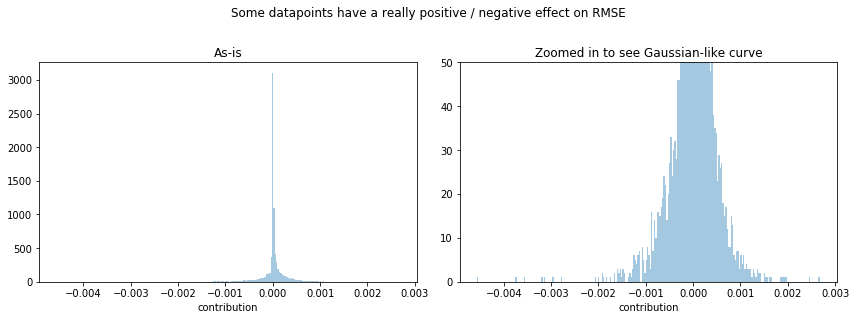

In [404]:
fig, ax = plt.subplots(figsize = (12, 5), ncols = 2)

sns.distplot(object_importances['contribution'], kde = False, bins = 250, ax = ax[0])
sns.distplot(object_importances['contribution'], kde = False, bins = 250, ax = ax[1])

plt.suptitle('Some datapoints have a really positive / negative effect on RMSE')
ax[0].set_title('As-is')
ax[1].set_title('Zoomed in to see Gaussian-like curve')
ax[1].set_ylim(0, 50)

plt.tight_layout(rect = [0, 0.1, 1, 0.9])
plt.show()

#### Which ones are these?

In [405]:
X_train.reset_index().merge(object_importances, left_on = 'index', right_on = 'train_index').sort_values('contribution')

index  is_male  is_loyal_customer  age  is_business_travel     class  \
512     512        0                  0   38                   1  Business   
5506   5506        1                  1   38                   1  Business   
646     646        0                  1   58                   1       Eco   
3150   3150        0                  1   31                   1  Business   
7053   7053        0                  0   42                   1       Eco   
...     ...      ...                ...  ...                 ...       ...   
7386   7386        1                  1   47                   0       Eco   
7407   7407        0                  1   40                   1  Business   
2051   2051        1                  1   61                   0  Eco Plus   
6308   6308        0                  1   59                   0       Eco   
7789   7789        1                  1   28                   0  Eco Plus   

      flight distance  inflight wifi service  \
512               248                      2   
5506              986                      1   
646               337                      2   
3150              829                      2   
7053             1046                      3   
...               ...                    ...   
7386              493                      4   
7407              628                      4   
2051              550                      4   
6308             1015                      4   
7789              468                      4   

      departure/arrival time convenient  ease of online booking  ...  \
512                                   2                       2  ...   
5506                                  1                       1  ...   
646                                   3                       2  ...   
3150                                  2                       4  ...   
7053                                  3                       3  ...   
...                                 ...                     ...  ...   
7386                                  4                       4  ...   
7407                                  4                       4  ...   
2051                                  3                       4  ...   
6308                                  0                       4  ...   
7789                                  3                       4  ...   

      on-board service  leg room service  baggage handling  checkin service  \
512                  5                 4                 4                5   
5506                 2                 2                 2                2   
646                  2                 2                 2                4   
3150                 3                 2                 4                3   
7053                 3                 3                 1                3   
...                ...               ...               ...              ...   
7386                 5                 2                 5                4   
7407                 4                 4                 4                2   
2051                 1                 3                 3                4   
6308                 3                 4                 3                3   
7789                 1                 3                 3                4   

      inflight service  cleanliness  departure delay in minutes  \
512                  5            4                           0   
5506                 2            2                           0   
646                  2            3                           0   
3150                 4            2                           0   
7053                 5            3                          33   
...                ...          ...                         ...   
7386                 4            2                           2   
7407                 4            3                          20   
2051                 4            3                           0   
6308    